# Important Configurations

We will initialize different configurations that will be used throughout this notebook

In [1]:
import os
from utils.config import HF_TOKEN, open_ai_key
import warnings
from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_huggingface  import HuggingFaceEmbeddings

# Ignore all the warnings given by different packages
warnings.filterwarnings('ignore')

# Retrieve the open ai and hf tokens from the configuration file
os.environ["HUGGINGFACEHUB_API_TOKEN"] = HF_TOKEN
os.environ["OPENAI_API_KEY"] = open_ai_key

# Select the GPU as the device
model_kwargs = {'device': 'cuda'}

# Required for fast similarity computations
encode_kwargs = {'normalize_embeddings': True}

# Initialize Embeddings, GPT and Ollama Model
llm_gpt = ChatOpenAI(model_name="gpt-4o-mini", openai_api_key=open_ai_key)

model_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-large-en-v1.5",
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,
)

# Load All the Documents

There are around 20 HR Policies documents for the Indian context present in folder data.

These policies can be downloaded by running the data_downloader.py script

In [3]:
from langchain_community.document_loaders import PyMuPDFLoader
import os

pdf_folder_path = "./utils/data"
documents = []
for file in os.listdir(pdf_folder_path):
    if file.endswith('.pdf'):
        pdf_path = os.path.join(pdf_folder_path, file)
        loader = PyMuPDFLoader(pdf_path)
        documents.extend(loader.load())
        
print(f"total documents loaded - {len(documents)}")

total documents loaded - 427


# Vector DB Initialization

We will create a reusable function which either stores the embeddings (if load is False) or loads the embeddings from the disk (if load is True)

In [4]:
from langchain_chroma import Chroma


def create_or_load_vector_db(chunked_documents, persist_directory, load=True):
    if load:
        vectordb = Chroma(
            persist_directory=persist_directory,
            embedding_function=model_embeddings,
        )

    else:
        vectordb = Chroma.from_documents(
            documents=chunked_documents,
            embedding=model_embeddings,
            persist_directory=persist_directory,
        )
    
    return vectordb

# Chunking Strategies

In this notebook, we will explore various chunking strategies to process data efficiently. Below is a list of the strategies we will be experimenting with:

1. **Fixed Length Chunking**
   - Chunk size: 1000
   - Overlap: 128

2. **Recursive Chunking**
   - Chunk size: 1000
   - Overlap: 128

3. **Recursive Chunking**
   - Chunk size: 4096
   - Overlap: 128

4. **Recursive Chunking**
   - Chunk size: 2048
   - Overlap: 128

5. **Recursive Chunking**
   - Chunk size: 512
   - Overlap: 128

6. **Recursive Chunking**
   - Chunk size: 256
   - Overlap: 128

7. **Semantic Chunking** with Percentile

8. **Semantic Chunking** with Standard Deviation

9. **Semantic Chunking** with Inter Quartile Range

10. **Semantic Chunking** with Gradient

11. **Page-based Chunking**

12. **Agentic Chunking** (According to Paper)

13. **Custom Agentic Chunking**

## Fixed Length Chunking

In this experiment we are setting a Fixed Length of **1000**. So the split will be based on the separator "\n\n"

We set a chunk overlap of 128. This means **128** tokens of the previous chunk will be present in the next chunk, to maintain the consistency and context

In [5]:
from langchain.text_splitter import CharacterTextSplitter

# Decide if split has already been done or not
split = False

if split:
    # If first time, do the splitting and store in Vector DB
    text_splitter = CharacterTextSplitter(
    separator = "\n\n",
    chunk_size = 1000,
    chunk_overlap  = 128
    )
    
    chunked_documents_fixed  = text_splitter.split_documents(documents)
    
    vectordb_fixed = create_or_load_vector_db(chunked_documents=chunked_documents_fixed, persist_directory="./vector_store_fixed", load=False)

else:
    # If not the first time, retrieve from Vector DB
   vectordb_fixed = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_fixed", load=True) 

## Recursive Chunking

This method is similar to Fixed Length, but only difference is that it tries more to have our chunk size less that or equal to the parameter we provided (Which is 1000)

This is done, by looking at the first seperator (suppose '\n\n'). If that doesn't lead to split <=1000 then second separator (may be '\n') and so on

### 1000 Tokens based Chunking

We will use parameter of 1000 chunk size and 128 overlap

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

split = False

if split:
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 1000,
        chunk_overlap  = 128
        )

    chunked_documents_recursive  = text_splitter.split_documents(documents)

    vectordb_recursive = create_or_load_vector_db(chunked_documents=chunked_documents_recursive, persist_directory="./vector_store_recursive", load=False)

else:
   vectordb_fixed = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_fixed", load=True) 

### Recursive Chunking Other Variations

We will configure different other chunk and overlap size variations and store all of then in Vector DB

In [78]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# With configuration of 256/64
text_splitter_256 = RecursiveCharacterTextSplitter(
chunk_size = 256,
chunk_overlap  = 64
)

# With configuration of 512/128
text_splitter_512 = RecursiveCharacterTextSplitter(
chunk_size = 512,
chunk_overlap  = 128
)

# With configuration of 2048/512
text_splitter_2048 = RecursiveCharacterTextSplitter(
chunk_size = 2048,
chunk_overlap  = 512
)

# With configuration of 4096/1024
text_splitter_4096 = RecursiveCharacterTextSplitter(
chunk_size = 4096,
chunk_overlap  = 1024
)


splitting_dict = {"vector_store_recursive_256": text_splitter_256, "vector_store_recursive_512": text_splitter_512,
    "vector_store_recursive_2048": text_splitter_2048, "vector_store_recursive_4096": text_splitter_4096}

# Start the Split and Store, recursively
for vector_store, splitter in splitting_dict.items():
    print(f"Starting Chunking of Documents - {vector_store}")
    chunked_documents  = splitter.split_documents(documents)
    print(f"Chunking complete. Storing to Vector DB")
    create_or_load_vector_db(chunked_documents=chunked_documents, persist_directory=f"./{vector_store}", load=False)
    print(f"Storage Complete - {vector_store}")


%|                                                                                                                                           | 0/4 [00:00<?, ?it/s]

Starting Chunking of Documents - vector_store_recursive_256
Chunking complete. Storing to Vector DB



%|████████████████████████████████▊                                                                                                  | 1/4 [01:25<04:16, 85.44s/it]

Storage Complete - vector_store_recursive_256
Starting Chunking of Documents - vector_store_recursive_512
Chunking complete. Storing to Vector DB


Exception ignored in: <function tqdm.__del__ at 0x7f71ff42d440>
Traceback (most recent call last):
  File "/opt/conda/envs/rag/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/opt/conda/envs/rag/lib/python3.11/site-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'

%|█████████████████████████████████████████████████████████████████▌                                                                 | 2/4 [02:47<02:47, 83.73s/it]

Storage Complete - vector_store_recursive_512
Starting Chunking of Documents - vector_store_recursive_2048
Chunking complete. Storing to Vector DB



%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 3/4 [03:46<01:12, 72.22s/it]

Storage Complete - vector_store_recursive_2048
Starting Chunking of Documents - vector_store_recursive_4096
Chunking complete. Storing to Vector DB



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [04:22<00:00, 65.68s/it]

Storage Complete - vector_store_recursive_4096


If already stored using the above step, load next time by running below step

In [7]:
vectordb_recursive_256 = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_recursive_256", load=True)
vectordb_recursive_512 = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_recursive_512", load=True)
vectordb_recursive_2048 = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_recursive_2048", load=True)
vectordb_recursive_4096 = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_recursive_4096", load=True)

## Semantic Chunking

This approach involves finding embeddings of every sentence and checking if it is similar to the embeddings of any other sentence. All the similar ones are clubbed together and made as a single chunk.

In [8]:
from langchain_experimental.text_splitter import SemanticChunker

split = False

if split:
    text_splitter = SemanticChunker(model_embeddings)
    chunked_documents_semantic  = text_splitter.split_documents(documents)
    vectordb_semantic = create_or_load_vector_db(chunked_documents=chunked_documents_semantic, persist_directory="./vector_store_semantic", load=False)
else:
    vectordb_semantic = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_semantic", load=True)

### Semantic Chunking with other variations

We can do semantic chunking with different variations. Below we are going to try 4 variations

1. **Percentile based**: Here sentence difference is based on Percentile. It will extract 500 chunks and to extract them it will change the threshold value dynamicallyt
2. **Standard Deviation based**: Here sentence difference is based on Standard Deviation. Chunk extraction is same as above
3. **Inter Quartile Based**: Here its Inter Quartile based. Chunk extraction method is same
4. **Gradient Based**: It finds difference between gradients of percentile and based on it finds chunks

In [73]:
text_splitter_percentile = SemanticChunker(embeddings = model_embeddings, breakpoint_threshold_type="percentile", number_of_chunks=500)
text_splitter_sd = SemanticChunker(embeddings = model_embeddings, breakpoint_threshold_type="standard_deviation", number_of_chunks=500)
text_splitter_iq = SemanticChunker(embeddings = model_embeddings, breakpoint_threshold_type="interquartile", number_of_chunks=500)
text_splitter_gradient = SemanticChunker(embeddings = model_embeddings, breakpoint_threshold_type="gradient", number_of_chunks=500)

In [76]:
chunked_documents_semantic_percentile  = text_splitter_percentile.split_documents(documents)
print("Done Percentile")
chunked_documents_semantic_sd  = text_splitter_sd.split_documents(documents)
print("Done SD")
chunked_documents_semantic_iq  = text_splitter_iq.split_documents(documents)
print("Done IQ")
chunked_documents_semantic_gradient  = text_splitter_gradient.split_documents(documents)
print("Done Gradient")

Done Percentile
Done SD
Done IQ
Done Gradient


In [78]:
vectordb_semantic_percentile = create_or_load_vector_db(chunked_documents=chunked_documents_semantic_percentile, persist_directory="./vector_store_semantic_percentile", load=False)
vectordb_semantic_sd = create_or_load_vector_db(chunked_documents=chunked_documents_semantic_sd, persist_directory="./vector_store_semantic_sd", load=False)
vectordb_semantic_iq = create_or_load_vector_db(chunked_documents=chunked_documents_semantic_iq, persist_directory="./vector_store_semantic_iq", load=False)
vectordb_semantic_gradient = create_or_load_vector_db(chunked_documents=chunked_documents_semantic_gradient, persist_directory="./vector_store_semantic_gradient", load=False)

## Page based Chunking

Here all the pages extracted from each document will be converted into a chunk. Very basic approach

In [9]:
vectordb_page = create_or_load_vector_db(chunked_documents="", persist_directory="./vector_store_page", load=True)

## Agentic Chunking

This is a new chunking method that uses llm and embeddings to generate propositions and then create chunks of these propositions.

We will understand this in detail

In [17]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub


First we will extract the proposals extraction prompt from the hugging face hub. We can create our own, but its a tried and tested one

In [18]:
proposition_prompt = hub.pull("wfh/proposal-indexing")

The system message of the prompt contains the core of proposals extraction

In [19]:
print(proposition_prompt.messages[0].prompt.template)

Decompose the "Content" into clear and simple propositions, ensuring they are interpretable out of
context.
1. Split compound sentence into simple sentences. Maintain the original phrasing from the input
whenever possible.
2. For any named entity that is accompanied by additional descriptive information, separate this
information into its own distinct proposition.
3. Decontextualize the proposition by adding necessary modifier to nouns or entire sentences
and replacing pronouns (e.g., "it", "he", "she", "they", "this", "that") with the full name of the
entities they refer to.
4. Present the results as a list of strings, formatted in JSON.

Example:

Input: Title: ¯Eostre. Section: Theories and interpretations, Connection to Easter Hares. Content:
The earliest evidence for the Easter Hare (Osterhase) was recorded in south-west Germany in
1678 by the professor of medicine Georg Franck von Franckenau, but it remained unknown in
other parts of Germany until the 18th century. Scholar Richar

Next we will see what we expect from the LLM in Input Message. We will mae a small change to it as well for our HR context

In [20]:
proposition_prompt.messages[1].prompt.template = proposition_prompt.messages[1].prompt.template + "\n\n" + "This data is regarding HR Policies of India. Generate Proposistions and do decompositions accordingly"
print(proposition_prompt.messages[1].prompt.template)

Decompose the following:
{input}

This data is regarding HR Policies of India. Generate Proposistions and do decompositions accordingly


Next, we will initialize the llm with the prompt, which later can be invoked

In [21]:
runnable = proposition_prompt | llm_gpt

First we will decide the output format. We will use Pydantic to inform llm that we want output which is in json format and has a key sentences

In [22]:
from langchain_core.pydantic_v1 import BaseModel, Field

# Pydantic Class defining the structure of output
class Sentences(BaseModel):
    sentences: List[str] = Field(
        description="These are the paragraphs from an HR policy"
    )

# Initializing a chain which gives a structured output
extraction_chain = llm_gpt.with_structured_output(Sentences)

Let's define a function that takes a document as input and returns propositions, based on our prompt, as output

In [23]:
def get_propositions(text):
    """
        We will take a document, extract propositions out of it based on our Prompt
    """
    # Pass the document to the runnable we created. It will give us the propositions
    runnable_output = runnable.invoke({"input": text}).content

    # We will extract the propositions from the above output into sentences.
    propositions = extraction_chain.invoke(runnable_output)
    
    return propositions

Now, for all the documents I will run the above function to extract propositions and store it in a list. We will use parallal processing to make the execution faster

In [ ]:
import concurrent.futures
import json

essay_propositions = []


def process_paragraph(para):
    """Utility function for parallelization"""
    propositions = get_propositions(para.page_content)
    return propositions.sentences

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = {
        executor.submit(process_paragraph, para): i for i, para in enumerate(documents)
    }

    for future in concurrent.futures.as_completed(futures):
        i = futures[future]  # Get the paragraph index
        try:
            essay_propositions.extend(future.result())
        except Exception as e:
            print(f"Error processing paragraph {i}: {e}")
        print(f"Done with {i}")

/opt/conda/envs/rag/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1369: UserWarning: Received a Pydantic BaseModel V1 schema. This is not supported by method="json_schema". Please use method="function_calling" or specify schema via JSON Schema or Pydantic V2 BaseModel. Overriding to method="function_calling".
  warnings.warn(
Processing paragraphs:   0%|▎                                                                                                                                               | 1/427 [00:00<05:39,  1.25it/s]

Done with 1


Processing paragraphs:   0%|▋                                                                                                                                               | 2/427 [00:01<06:44,  1.05it/s]

Done with 2


Processing paragraphs:   1%|█                                                                                                                                               | 3/427 [00:03<09:18,  1.32s/it]

Done with 0


Processing paragraphs:   1%|█▎                                                                                                                                              | 4/427 [00:13<32:29,  4.61s/it]

Done with 5


Processing paragraphs:   1%|█▋                                                                                                                                              | 5/427 [00:17<30:55,  4.40s/it]

Done with 3


Processing paragraphs:   1%|██                                                                                                                                              | 6/427 [00:20<28:28,  4.06s/it]

Done with 7


Processing paragraphs:   2%|██▎                                                                                                                                             | 7/427 [00:21<21:00,  3.00s/it]

Done with 4


Processing paragraphs:   2%|██▋                                                                                                                                             | 8/427 [00:24<20:04,  2.87s/it]

Done with 6


Processing paragraphs:   2%|███                                                                                                                                             | 9/427 [00:33<35:10,  5.05s/it]

Done with 8


Processing paragraphs:   2%|███▎                                                                                                                                           | 10/427 [00:34<24:46,  3.56s/it]

Done with 11


Processing paragraphs:   3%|███▋                                                                                                                                           | 11/427 [00:38<26:25,  3.81s/it]

Done with 12


Processing paragraphs:   3%|████                                                                                                                                           | 12/427 [00:42<26:34,  3.84s/it]

Done with 9


Processing paragraphs:   3%|████▎                                                                                                                                          | 13/427 [00:42<18:53,  2.74s/it]

Done with 10


Processing paragraphs:   3%|████▋                                                                                                                                          | 14/427 [00:53<36:29,  5.30s/it]

Done with 13


Processing paragraphs:   4%|█████▎                                                                                                                                         | 16/427 [00:56<22:09,  3.23s/it]

Done with 15
Done with 16


Processing paragraphs:   4%|█████▋                                                                                                                                         | 17/427 [00:59<21:29,  3.14s/it]

Done with 14
Done with 17


Processing paragraphs:   4%|██████▎                                                                                                                                        | 19/427 [01:07<24:18,  3.57s/it]

Done with 18


Processing paragraphs:   5%|██████▋                                                                                                                                        | 20/427 [01:12<25:14,  3.72s/it]

Done with 19


Processing paragraphs:   5%|███████                                                                                                                                        | 21/427 [01:12<20:04,  2.97s/it]

Done with 22


Processing paragraphs:   5%|███████▎                                                                                                                                       | 22/427 [01:13<14:57,  2.22s/it]

Done with 21


Processing paragraphs:   5%|███████▋                                                                                                                                       | 23/427 [01:18<20:35,  3.06s/it]

Done with 20


Processing paragraphs:   5%|███████▋                                                                                                                                       | 23/427 [01:21<23:48,  3.54s/it]


KeyboardInterrupt: 

Let's persist the propositions, so that we don't need to run it everytime we open the notebook

In [ ]:
temp_dict = {}

temp_dict["essay_propositions"] = essay_propositions

with open("essay_propositions.json", 'w') as file:
    json.dump(temp_dict, file, indent=4)

In [ ]:
import concurrent.futures


import logging
logging.getLogger().setLevel(logging.ERROR)


import json
from AgenticChunker import AgenticChunker

with open("essay_propositions.json", 'r') as file:
    essay_propositions = json.load(file)
    
essay_propositions = essay_propositions["essay_propositions"]
    
# Initialize the shared AgenticChunker instance
ac = AgenticChunker()

def process_single_proposition(proposition):
    """Worker function to process a single proposition in the shared AgenticChunker instance."""
    ac.add_proposition(proposition)

def process_propositions_parallel(essay_propositions, max_workers=50):
    """
    Processes propositions in parallel using a shared AgenticChunker instance.
    Each batch contains at most `max_workers` propositions.
    """
    # Using ThreadPoolExecutor with 10 workers
    with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Submitting the propositions in batches of `max_workers`
        for i in range(0, len(essay_propositions), max_workers):
            batch = essay_propositions[i:i + max_workers]
            futures = [executor.submit(process_single_proposition, prop) for prop in batch]

            # Wait for batch completion before submitting the next batch
            concurrent.futures.wait(futures)
            print(f"Finished {i} chunks")
    
    # Return the final chunks after all propositions are processed
    return ac.get_chunks(get_type='dict')

# Run parallel processing
final_chunks = process_propositions_parallel(essay_propositions)

chunked_documents = {}
for i, (id, chunk) in enumerate(final_chunks.items()):
    final_string = ""
    final_string += f"Title: {chunk['title']}\n\n"
    final_string += f"Summary: {chunk['summary']}\n\n"
    propositions = [("").join(p) for p in chunk["propositions"]]
    final_string += f"Propositions:\n {propositions[0]}"
    chunked_documents[f"chunk_{i}"] = final_string

with open("agentic_chunks.json", 'w') as file:
    json.dump(chunked_documents, file, indent=4)

In [47]:
import json
with open("./agentic_chunks.json", 'r') as file:
    chunked_documents = json.load(file)

# vectordb_agentic = create_or_load_vector_db(chunked_documents=chunked_documents, persist_directory="./vector_store_agentic", load=True)

In [50]:
from langchain_core.documents import Document

chunks = []
for k, v in chunked_documents.items():
    chunks.append(Document(page_content=v))

In [51]:
vectordb_agentic = create_or_load_vector_db(chunked_documents=chunks, persist_directory="./vector_store_agentic", load=False)

## Agentic Chunking - Custom

In [54]:
from langchain.output_parsers.openai_tools import JsonOutputToolsParser
from langchain_community.chat_models import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda
from langchain.chains import create_extraction_chain
from typing import Optional, List
from langchain.chains import create_extraction_chain_pydantic
from langchain_core.pydantic_v1 import BaseModel
from langchain import hub

In [55]:
proposition_prompt = hub.pull("wfh/proposal-indexing")
proposition_prompt.messages[1].prompt.template = proposition_prompt.messages[1].prompt.template + "\n\n" + "This data is regarding HR Policies of India. Generate Proposistions and do decompositions accordingly"
runnable = proposition_prompt | llm_gpt

In [56]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
chunk_size = 2048,
chunk_overlap  = 512
)

chunked_documents_recursive  = text_splitter.split_documents(documents)

In [57]:
from langchain_core.pydantic_v1 import BaseModel, Field
import concurrent.futures
import json


class Sentences(BaseModel):
    sentences: List[str] = Field(
        description="These are the paragraphs from an HR policy"
    )


extraction_chain = llm_gpt.with_structured_output(Sentences)


def get_propositions(text):
    runnable_output = runnable.invoke({"input": text}).content
    propositions = extraction_chain.invoke(runnable_output)
    return propositions


essay_propositions = []


def process_paragraph(para):
    """Extracts propositions from a paragraph."""
    propositions = get_propositions(para.page_content)
    return propositions.sentences

chunk_propositions = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    futures = {
        executor.submit(process_paragraph, para): i for i, para in enumerate(chunked_documents_recursive)
    }

    for future in concurrent.futures.as_completed(futures):
        i = futures[future]
        try:
            chunk_propositions[f"chunk_{i}"] = future.result()
        except Exception as e:
            print(f"Error processing paragraph {i}: {e}")
        print(f"Done with {i}")

Done with 4
Done with 2
Done with 6
Done with 1
Done with 3
Done with 8
Done with 0
Done with 5
Done with 7
Done with 9
Done with 10
Done with 12
Done with 14
Done with 16
Done with 11
Done with 13
Done with 15
Done with 18
Done with 17
Done with 20
Done with 23
Done with 25
Done with 19
Done with 22
Done with 24
Done with 21
Done with 29
Done with 27
Done with 26
Done with 30
Done with 28
Done with 31
Done with 35
Done with 33
Done with 34
Done with 36
Done with 32
Done with 37
Done with 41
Done with 39
Done with 44
Done with 42
Done with 38
Done with 43
Done with 46
Done with 47
Done with 45
Done with 40
Done with 48
Done with 49
Done with 50
Done with 51
Done with 52
Done with 53
Done with 54
Done with 57
Done with 55
Done with 56
Done with 58
Done with 60
Done with 59
Done with 62
Done with 61
Done with 63
Done with 67
Done with 64
Done with 66
Done with 69
Done with 68
Done with 70
Done with 73
Done with 71
Done with 76
Done with 72
Done with 65
Done with 75
Done with 78
Done with

In [69]:
from langchain_core.documents import Document

chunks = []

for k, v in chunk_propositions.items():
    chunk = Document(page_content="\n".join(v))
    chunks.append(chunk)

In [70]:
vectordb_agentic_custom = create_or_load_vector_db(chunked_documents=chunks, persist_directory="./vector_store_agentic_custom", load=False)

# Creating a Retrieval & Generation

In [32]:
from langchain_ollama import ChatOllama

llm = ChatOllama(
    model="llama3.2:1b",
    temperature=0.5,
    num_predict = 512,
    num_thread = 2,
    num_ctx = 256,
    format = 'json'
)

In [33]:
from langchain_core.runnables import RunnableParallel
from langchain_core.runnables import RunnablePassthrough
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def get_llm_response(query, vectordb):
    retriever = vectordb.as_retriever()
    prompt = hub.pull("rlm/rag-prompt")
    rag_chain_from_docs = (
            RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
            | prompt
            | llm
            | StrOutputParser()
        )
    rag_chain_with_source = RunnableParallel(
            {"context": retriever, "question": RunnablePassthrough()}
            ).assign(answer=rag_chain_from_docs)
    result = rag_chain_with_source.invoke(query)
    return result["answer"], result["context"]

In [34]:
import concurrent.futures
import tqdm

def process_llm_response(k, v, vectordb):
    """Function to fetch LLM response in parallel."""
    answer, context = get_llm_response(v["question"], vectordb)
    return k, {"question": v["question"], "answer": answer, "context": [s.page_content for s in context]}

def get_response(cleaned_data, vectordb):
    llm_response_data = {}
    with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
        futures = {executor.submit(process_llm_response, k, v, vectordb): k for k, v in cleaned_data.items()}
        
        for future in tqdm.tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
            k, result = future.result()
            llm_response_data[k] = result
        return llm_response_data

# Evaluation

In [35]:
# Generate small subset of test data

with open("./utils/test_data.json", "r") as file:
    temp = json.load(file)

all_keys = random.sample(list(temp.keys()), 30)
cleaned_data = {}
for key in all_keys:
    cleaned_data[key] = temp[key]

with open("test_data_30.json", 'w') as file:
    json.dump(cleaned_data, file, indent=4)

In [38]:
import pandas as pd
from ragas import SingleTurnSample, EvaluationDataset
from ragas import evaluate
from ragas.run_config import RunConfig
import warnings
import random
import time

from ragas.metrics import LLMContextPrecisionWithReference, LLMContextRecall, ResponseRelevancy, Faithfulness

warnings.filterwarnings('ignore')
        
def save_evaluator_results(result, name):
    result.to_csv(f"evaluation_{name}.csv")

def evaluator(name, vectordb, cleaned_data):
    data_list = []
    llm_response_data = get_response(cleaned_data, vectordb)
    
    with open(f"llm_response_data_{name}.json", "w") as file:
        json.dump(llm_response_data, file, indent=4)
    
    for k, v in llm_response_data.items():
        row = SingleTurnSample(
            user_input=v["question"],
            retrieved_contexts=v["context"],
            response=v["answer"],
            reference=cleaned_data[k]["answer"],
            reference_contexts = [cleaned_data[k]["answer"]]
        )
    
        data_list.append(row)
    dataset = EvaluationDataset(samples=data_list)
    
    
    result_1 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[LLMContextPrecisionWithReference(), LLMContextRecall()]).to_pandas()

    time.sleep(30)
    
    result_2 = evaluate(dataset, llm=llm_gpt, embeddings=model_embeddings, run_config=RunConfig(max_workers=10, max_retries=20, timeout=180), 
                      metrics=[ResponseRelevancy(), Faithfulness()]).to_pandas()

    result = pd.merge(result_1, result_2[['user_input', 'answer_relevancy', 'faithfulness']], on='user_input')
    
    save_evaluator_results(result, name)
    
 
    return result

In [40]:
import time
import json

with open("test_data_30.json", "r") as file:
    cleaned_data = json.load(file)

experiments = {
    "recursive_4096": vectordb_recursive_4096,
    "recursive_2048": vectordb_recursive_2048,
    "recursive_512": vectordb_recursive_512,
    "recursive_256": vectordb_recursive_256,
    "recursive_1024": vectordb_recursive,
    "fixed": vectordb_fixed,
    "semantic": vectordb_semantic,
    "page": vectordb_page,
    "agentic": vectordb_agentic
    }

results = {}

for experiment_name, experiment_db in experiments.items():
    results[experiment_name] = evaluator(experiment_name, experiment_db, cleaned_data)
    time.sleep(60)
    print(f"experiment {experiment_name} completed")

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.43it/s]


experiment recursive_4096 completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:43<00:00,  1.36it/s]


experiment recursive_2048 completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:53<00:00,  1.13it/s]


experiment recursive_512 completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:19<00:00,  3.05it/s]


experiment recursive_256 completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:37<00:00,  1.63s/it]


experiment recursive_1024 completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [02:19<00:00,  2.33s/it]


experiment fixed completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [01:00<00:00,  1.01s/it]


experiment semantic completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:30<00:00,  1.96it/s]


experiment page completed


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:18<00:00,  3.18it/s]


experiment agentic completed


In [52]:
results["agentic"] = evaluator("agentic", vectordb_agentic, cleaned_data)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:41<00:00,  1.44it/s]


In [71]:
results["agentic_custom"] = evaluator("agentic_custom", vectordb_agentic_custom, cleaned_data)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:47<00:00,  1.27it/s]


In [79]:
results["semantic_percentile"] = evaluator("semantic_percentile", vectordb_semantic_percentile, cleaned_data)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:40<00:00,  1.49it/s]


In [80]:
results["semantic_sd"] = evaluator("semantic_sd", vectordb_semantic_sd, cleaned_data)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:28<00:00,  2.12it/s]


In [81]:
results["semantic_iq"] = evaluator("semantic_iq", vectordb_semantic_iq, cleaned_data)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:33<00:00,  1.77it/s]


In [82]:
results["semantic_gradient"] = evaluator("semantic_gradient", vectordb_semantic_gradient, cleaned_data)

Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:40<00:00,  1.48it/s]


# Publishing Results to WandB

In [72]:
import wandb

wandb.init(project="Advanced RAG Experiments", name="Detailed Chunking Experiments")

metrics = ["answer_relevancy", "context_precision", "faithfulness", "context_recall"]
for m in metrics:
    labels = ['Fixed', 'Recursive', 'Semantic', 'Agentic', "Page"]
    values = [
        np.mean(result_fixed[m]),
        np.mean(result_recursive[m]),
        np.mean(result_semantic[m]),
        np.mean(result_agentic[m]),
        np.mean(result_page[m])
    ]
    data = [[label,val] for (label,val) in zip(labels,values)]
    
    table = wandb.Table(data=data, columns = ["Chunking Type", m])
    
    wandb.log({f"{m} Evaluation": wandb.plot.bar(table,"Chunking Type", m, f"{m} Evaluation" )})

wandb.finish()

# Publishing Results Locally

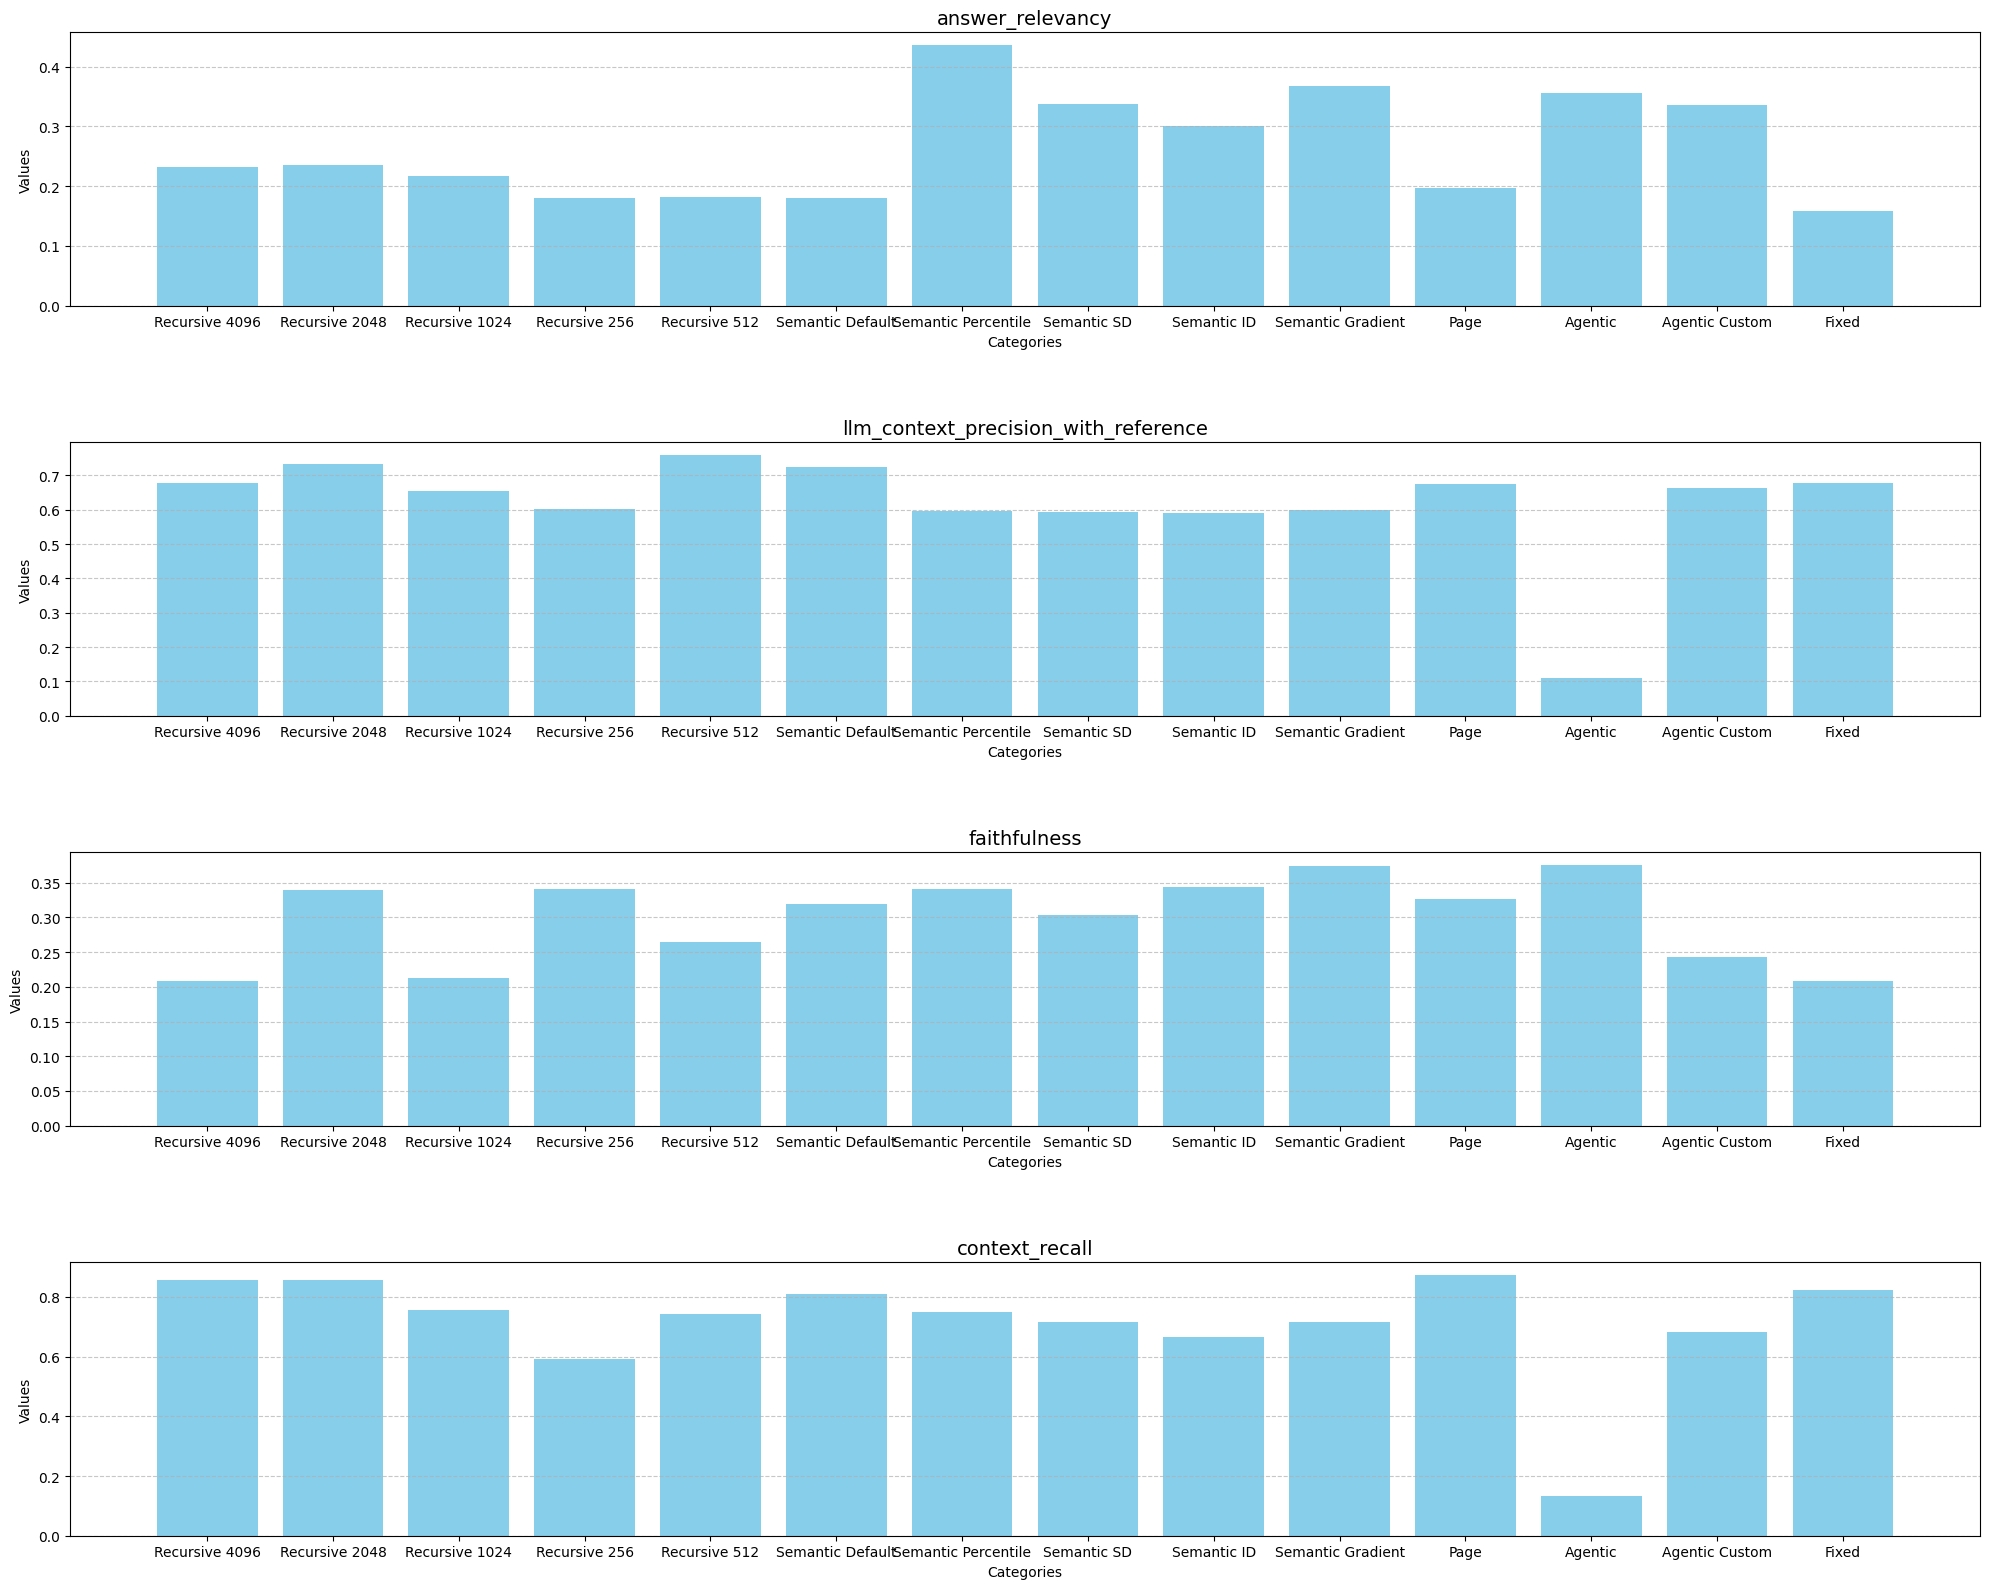

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
# categories = ['Fixed', 'Recursive', 'Semantic', 'Agentic', "Page"]

categories = ["Recursive 4096", "Recursive 2048", "Recursive 1024", "Recursive 256", "Recursive 512", "Semantic Default", "Semantic Percentile", "Semantic SD", "Semantic ID", "Semantic Gradient", "Page", "Agentic", "Agentic Custom", "Fixed"]


metrics = ["answer_relevancy", "llm_context_precision_with_reference", "faithfulness", "context_recall"]

values = []
for m in metrics:
    values.append([
    np.mean(np.nan_to_num(results["recursive_4096"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_2048"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_1024"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_256"][m], nan=0)),
    np.mean(np.nan_to_num(results["recursive_512"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_percentile"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_sd"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_iq"][m], nan=0)),
    np.mean(np.nan_to_num(results["semantic_gradient"][m], nan=0)),
    np.mean(np.nan_to_num(results["page"][m], nan=0)),
    np.mean(np.nan_to_num(results["agentic"][m], nan=0)),
    np.mean(np.nan_to_num(results["agentic_custom"][m], nan=0)),
    np.mean(np.nan_to_num(results["fixed"][m], nan=0))
])

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(4,1, figsize=(20, 16))

# Titles for each subplot
titles = ['Plot 1', 'Plot 2', 'Plot 3', 'Plot 4']

# Iterate over each subplot and create a bar plot
for i, ax in enumerate(axs.flat):
    ax.bar(categories, values[i], color='skyblue')
    ax.set_title(metrics[i], fontsize=14)
    ax.set_xlabel('Categories', fontsize=10)
    ax.set_ylabel('Values', fontsize=10)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap and add space between plots
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)

# Show the plots
plt.show()